In [1]:
# Core imports
import sys
import numpy as np
import pandas as pd
import scipy.sparse
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.cuda.amp import autocast, GradScaler
import scanpy as sc
from sklearn.metrics import f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt
sys.path.append("../model/")
from load import *


def evaluate(model, data_loader, device):
    """
    Evaluate model performance on given data loader
    Returns accuracy, F1 score, and prediction details
    """
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in data_loader:
            data, target = data.to(device), target.to(device)
            outputs = model({'x': data, 'targets': target})
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    accuracy = 100 * correct / total
    f1 = f1_score(all_targets, all_preds, average='weighted')
    return accuracy, f1, all_targets, all_preds


def prepare_data(expression_csv, adata):
    """
    Prepare data for model training
    Args:
        expression_csv: Path to expression data CSV
        adata: AnnData object containing cell annotations
    Returns:
        TensorDataset containing expression data and labels
    """
    # Load expression data from CSV
    X = pd.read_csv(expression_csv, index_col=0).values
    
    # Get labels from AnnData object
    y = adata.obs['celltype'].cat.codes.values
    
    # Convert to PyTorch tensors
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.LongTensor(y)
    
    return TensorDataset(X_tensor, y_tensor)


class LinearProbingClassifier(nn.Module):
    def __init__(self, ckpt_path, frozenmore=True):
        """
        Initialize the classifier
        Args:
            ckpt_path: Path to checkpoint file
            frozenmore: Whether to freeze additional layers
        """
        super().__init__()
        self.ckpt_path = ckpt_path
        self.frozenmore = frozenmore
        
    def build(self):
        """Build model architecture and load weights"""
        model, model_config = load_model_frommmf(self.ckpt_path)
        self.token_emb = model.token_emb
        self.pos_emb = model.pos_emb
        self.encoder = model.encoder
        
        if self.frozenmore:
            for _, p in self.token_emb.named_parameters():
                p.requires_grad = False
            for _, p in self.pos_emb.named_parameters():
                p.requires_grad = False
            print('self.pos_emb and self.token_emb also frozen')
        
        # Freeze encoder layers except second to last
        for na, param in self.encoder.named_parameters():
            param.requires_grad = False
        for na, param in self.encoder.transformer_encoder[-2].named_parameters():
            print('self.encoder.transformer_encoder', na, 'have grad')
            param.requires_grad = True
            
        # Classification head
        self.fc1 = nn.Sequential(
            nn.Linear(model_config['encoder']['hidden_dim'], 256),
            nn.ReLU(),
            nn.Linear(256, 18)  # Number of classes
        ) 
        
        self.norm = torch.nn.BatchNorm1d(
            model_config['encoder']['hidden_dim'], 
            affine=False, 
            eps=1e-6
        )
        self.model_config = model_config
        
    def forward(self, sample_list, *args, **kwargs):
        """Forward pass of the model"""
        label = sample_list['targets']
        x = sample_list['x']  # (B, L)
        value_labels = x > 0
        x, x_padding = gatherData(x, value_labels, self.model_config['pad_token_id'])
        data_gene_ids = torch.arange(19264, device=x.device).repeat(x.shape[0], 1)
        position_gene_ids, _ = gatherData(
            data_gene_ids, 
            value_labels,
            self.model_config['pad_token_id']
        )
        
        # Embedding and position encoding
        x = self.token_emb(torch.unsqueeze(x, 2).float(), output_weight=0)
        position_emb = self.pos_emb(position_gene_ids)
        x += position_emb
        
        # Encoder and classification
        logits = self.encoder(x, x_padding)
        logits, _ = torch.max(logits, dim=1)  # b,dim
        logits = self.norm(logits)
        logits = self.fc1(logits)
        
        return logits

In [3]:
# Load expression data and labels
train_adata = sc.read_h5ad('c_data.h5ad')
test_adata = sc.read_h5ad('filtered_ms_adata.h5ad')

# Prepare datasets
train_dataset = prepare_data('MS_train_raw.csv', train_adata)
test_dataset = prepare_data('MS_test_raw.csv', test_adata)

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

/tmp/ipykernel_458/1926670781.py:55: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  y_tensor = torch.LongTensor(y)


In [4]:
# model = LinearProbingClassifier(ckpt_path='./models/models.ckpt')
# model.build()
# model = model.cuda()

best_model_path = 'best_model.pth'
best_model = LinearProbingClassifier(ckpt_path='./models/models.ckpt')
best_model.build()
best_model.load_state_dict(torch.load(best_model_path))
best_model = best_model.cuda()

test_accuracy, test_f1, all_targets, all_preds = evaluate(best_model, test_loader, torch.device("cuda"))
print(f"Best Model - Test Accuracy: {test_accuracy:.2f}%, Test F1 Score: {test_f1:.4f}")

/scFundation/scFoundation-main/model/load.py:125: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_data = torch.load(best_ckpt_path,map_location='cpu')


{'mask_gene_name': False, 'gene_num': 19266, 'seq_len': 19266, 'encoder': {'hidden_dim': 768, 'depth': 12, 'heads': 12, 'dim_head': 64, 'seq_len': 19266, 'module_type': 'transformer', 'norm_first': False}, 'decoder': {'hidden_dim': 512, 'depth': 6, 'heads': 8, 'dim_head': 64, 'module_type': 'performer', 'seq_len': 19266, 'norm_first': False}, 'n_class': 104, 'pad_token_id': 103, 'mask_token_id': 102, 'bin_num': 100, 'bin_alpha': 1.0, 'rawcount': True, 'model': 'mae_autobin', 'test_valid_train_idx_dict': '/nfs_beijing/minsheng/data/os10000w-new/global_shuffle/meta.csv.train_set_idx_dict.pt', 'valid_data_path': '/nfs_beijing/minsheng/data/valid_count_10w.npz', 'num_tokens': 13, 'train_data_path': None, 'isPanA': False, 'isPlanA1': False, 'max_files_to_load': 5, 'bin_type': 'auto_bin', 'value_mask_prob': 0.3, 'zero_mask_prob': 0.03, 'replace_prob': 0.8, 'random_token_prob': 0.1, 'mask_ignore_token_ids': [0], 'decoder_add_zero': True, 'mae_encoder_max_seq_len': 15000, 'isPlanA': False, 'ma

/tmp/ipykernel_458/3527350336.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_path))


Best Model - Test Accuracy: 80.31%, Test F1 Score: 0.8023


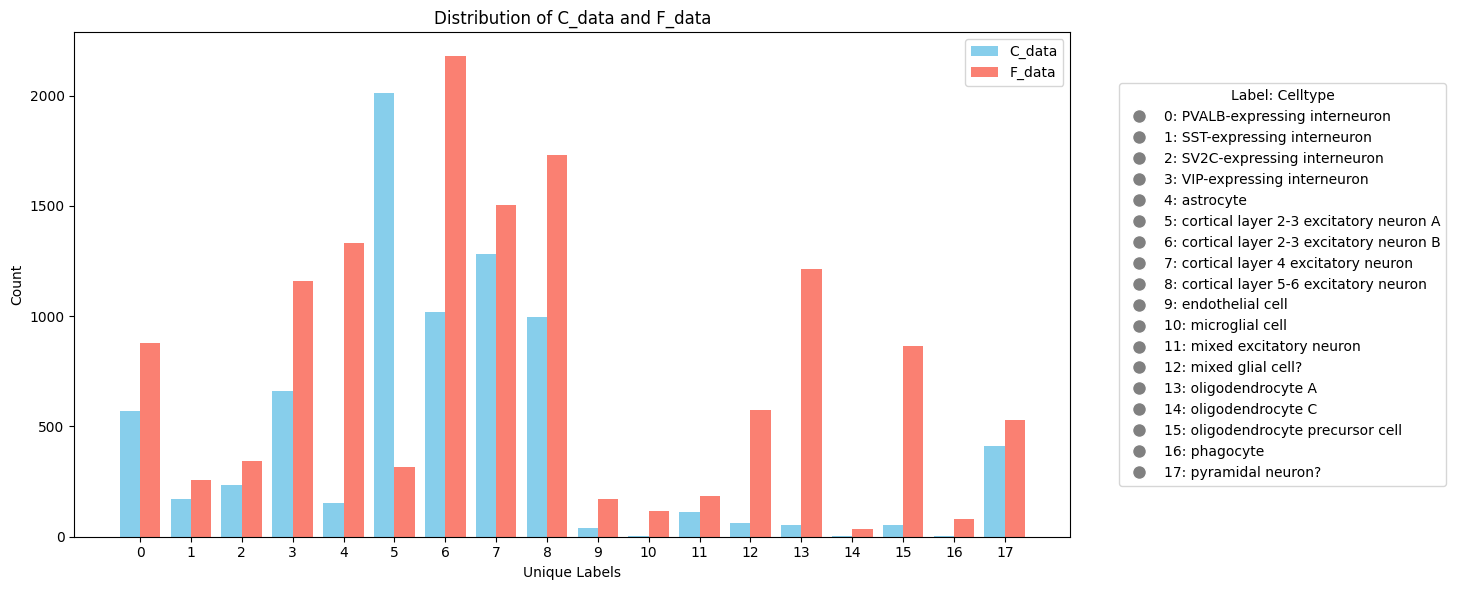

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate distribution of labels in both datasets
train_unique, train_counts = np.unique(y_train, return_counts=True)
test_unique, test_counts = np.unique(y_test, return_counts=True)

# Get mapping from numeric labels to cell types
label_to_celltype = dict(enumerate(train_adata.obs['celltype'].cat.categories))

# Create a wider figure to accommodate the legend
fig, (ax1, ax2) = plt.subplots(
    1, 2, 
    figsize=(15, 6), 
    gridspec_kw={'width_ratios': [3, 1]}
)

# Plot bar charts in the left subplot
ax1.bar(
    train_unique - 0.2, 
    train_counts, 
    width=0.4, 
    label='C_data', 
    color='skyblue', 
    align='center'
)
ax1.bar(
    test_unique + 0.2, 
    test_counts, 
    width=0.4, 
    label='F_data', 
    color='salmon', 
    align='center'
)

# Set labels and title for the left subplot
ax1.set_xlabel('Unique Labels')
ax1.set_ylabel('Count')
ax1.set_title('Distribution of C_data and F_data')
ax1.set_xticks(np.union1d(train_unique, test_unique))
ax1.legend()

# Create legend in the right subplot
legend_elements = [
    plt.Line2D(
        [0], [0],
        marker='o',
        color='w',
        label=f'{k}: {v}',
        markerfacecolor='gray',
        markersize=10
    ) 
    for k, v in label_to_celltype.items()
]

# Configure right subplot for legend display
ax2.legend(
    handles=legend_elements,
    title='Label: Celltype',
    loc='center'
)
ax2.axis('off')  # Hide axes

# Adjust layout and display
plt.tight_layout()
plt.show()

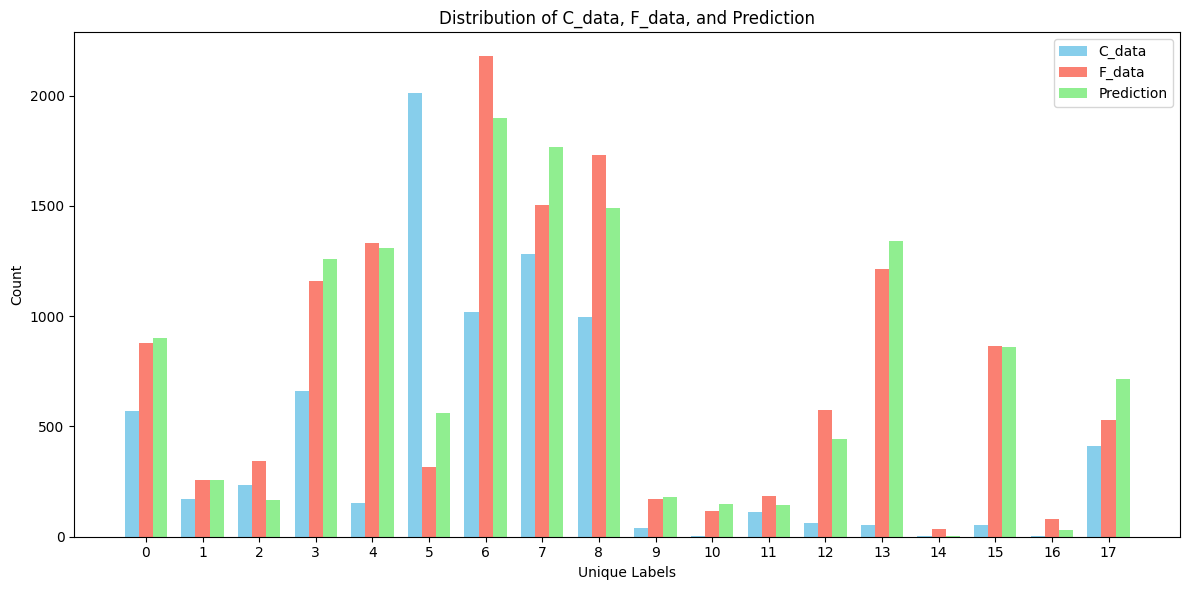

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate unique values and their counts for y_train, y_test, and pre
train_unique, train_counts = np.unique(y_train, return_counts=True)
test_unique, test_counts = np.unique(y_test, return_counts=True)
pre_unique, pre_counts = np.unique(all_preds, return_counts=True)

# Plot the distribution for y_train, y_test, and pre
plt.figure(figsize=(12, 6))
bar_width = 0.25

plt.bar(train_unique - bar_width, train_counts, width=bar_width, label='C_data', color='skyblue', align='center')
plt.bar(test_unique, test_counts, width=bar_width, label='F_data', color='salmon', align='center')
plt.bar(pre_unique + bar_width, pre_counts, width=bar_width, label='Prediction', color='lightgreen', align='center')

# Adding labels and title
plt.xlabel('Unique Labels')
plt.ylabel('Count')
plt.title('Distribution of C_data, F_data, and Prediction')
plt.xticks(np.unique(np.concatenate((train_unique, test_unique, pre_unique))))
plt.legend()

# Show plot
plt.tight_layout()
plt.show()

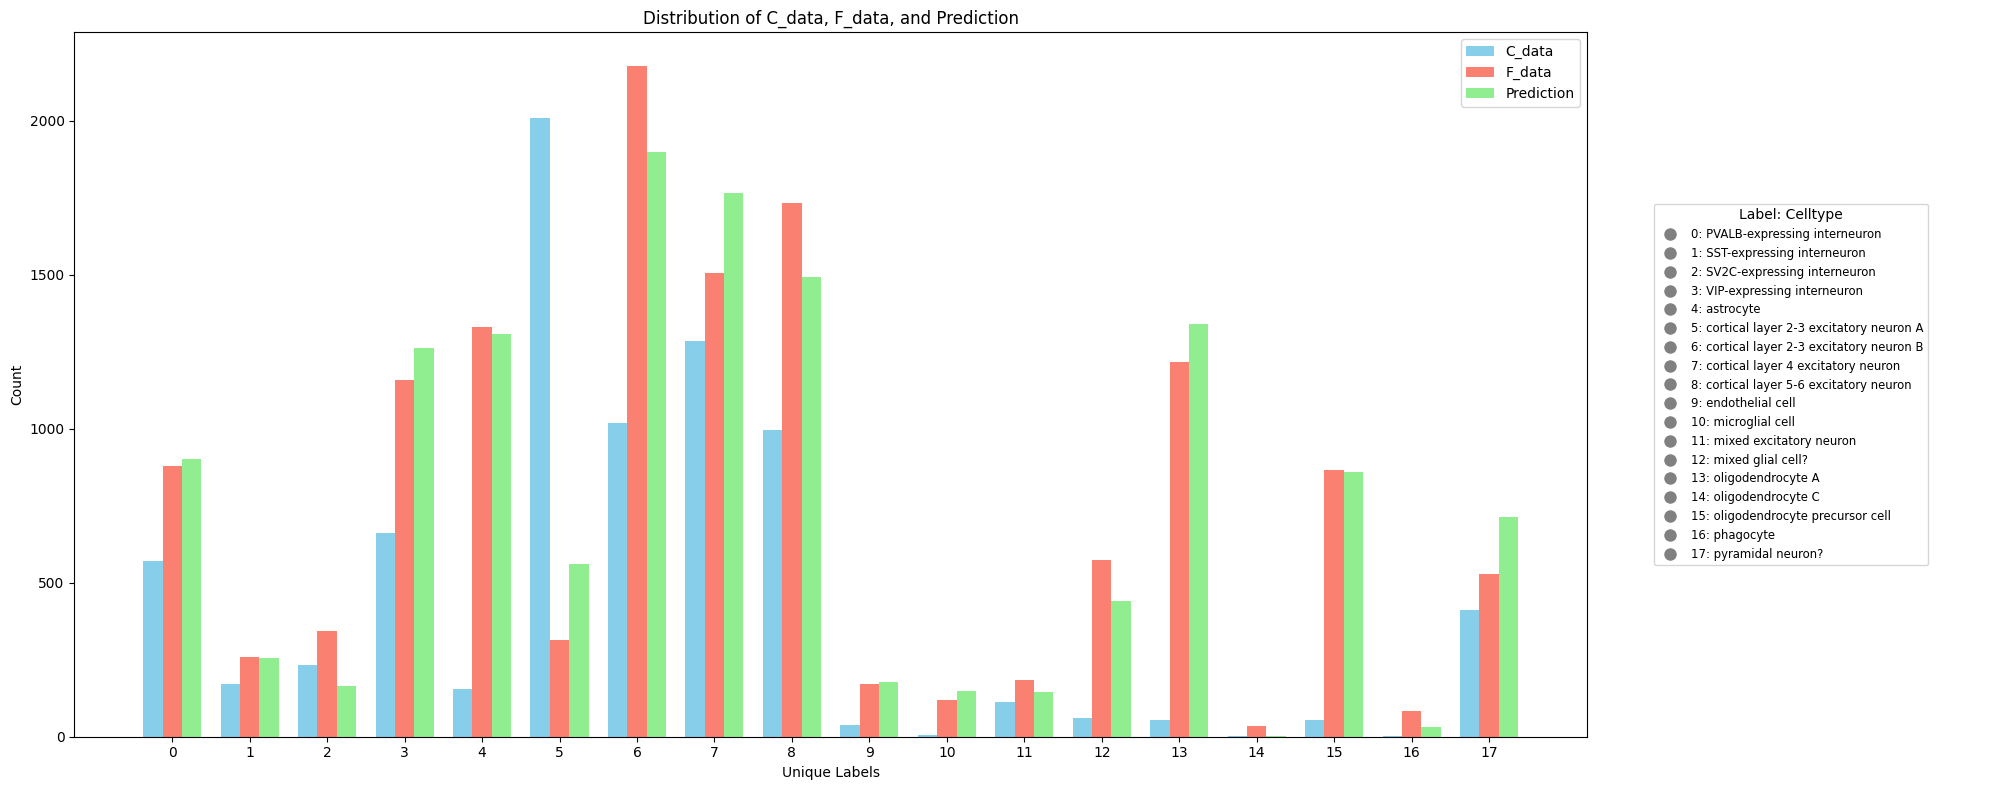

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate unique values and their counts for each dataset
train_unique, train_counts = np.unique(y_train, return_counts=True)
test_unique, test_counts = np.unique(y_test, return_counts=True)
pre_unique, pre_counts = np.unique(all_preds, return_counts=True)

# Get mapping from labels to cell types
label_to_celltype = dict(enumerate(train_adata.obs['celltype'].cat.categories))

# Create figure with wider layout to accommodate legend
fig, (ax1, ax2) = plt.subplots(
    1, 2, 
    figsize=(20, 8), 
    gridspec_kw={'width_ratios': [4, 1]}
)

# Plot grouped bar charts
bar_width = 0.25
ax1.bar(
    train_unique - bar_width,
    train_counts,
    width=bar_width,
    label='C_data',
    color='skyblue',
    align='center'
)
ax1.bar(
    test_unique,
    test_counts,
    width=bar_width,
    label='F_data',
    color='salmon',
    align='center'
)
ax1.bar(
    pre_unique + bar_width,
    pre_counts,
    width=bar_width,
    label='Prediction',
    color='lightgreen',
    align='center'
)

# Configure main plot labels and title
ax1.set_xlabel('Unique Labels')
ax1.set_ylabel('Count')
ax1.set_title('Distribution of C_data, F_data, and Prediction')
ax1.set_xticks(np.unique(np.concatenate((train_unique, test_unique, pre_unique))))
ax1.legend()

# Create legend mapping in the right subplot
legend_elements = [
    plt.Line2D(
        [0], [0],
        marker='o',
        color='w',
        label=f'{k}: {v}',
        markerfacecolor='gray',
        markersize=10
    ) 
    for k, v in label_to_celltype.items()
]

# Configure legend display
ax2.legend(
    handles=legend_elements,
    title='Label: Celltype',
    loc='center',
    fontsize='small'
)
ax2.axis('off')  # Hide axes

# Adjust layout and save
plt.tight_layout()
plt.savefig('Distribution.png')
plt.show()

In [9]:
import numpy as np
from scipy import stats
from scipy.spatial.distance import jensenshannon
from scipy.stats import wasserstein_distance


def compare_distributions(dist1, dist2, dist3, names):
    """
    Compare three distributions using different metrics
    
    Args:
        dist1, dist2, dist3: Input distributions to compare
        names: Names of the distributions
    
    Returns:
        Dictionary containing comparison matrices for different metrics
    """
    distributions = [dist1, dist2, dist3]
    n = len(names)
    
    # Initialize results storage
    results = {
        'KS Test': np.zeros((n, n)),
        'Jensen-Shannon': np.zeros((n, n)),
        'Wasserstein': np.zeros((n, n))
    }
    
    for i in range(n):
        for j in range(i+1, n):
            # Kolmogorov-Smirnov test
            ks_statistic, p_value = stats.ks_2samp(distributions[i], distributions[j])
            results['KS Test'][i, j] = ks_statistic
            results['KS Test'][j, i] = p_value
            
            # Calculate probability distributions
            hist1, _ = np.histogram(distributions[i], bins=50, density=True)
            hist2, _ = np.histogram(distributions[j], bins=50, density=True)
            
            # Jensen-Shannon divergence
            js_div = jensenshannon(hist1, hist2)
            results['Jensen-Shannon'][i, j] = results['Jensen-Shannon'][j, i] = js_div
            
            # Wasserstein distance
            w_dist = wasserstein_distance(distributions[i], distributions[j])
            results['Wasserstein'][i, j] = results['Wasserstein'][j, i] = w_dist
    
    return results


# Compare the distributions
names = ['C_data', 'F_data', 'Prediction']
results = compare_distributions(y_train, y_test, all_preds, names)

# Print results
for method, matrix in results.items():
    print(f"\n{method}:")
    print(pd.DataFrame(matrix, index=names, columns=names))


KS Test:
                   C_data    F_data  Prediction
C_data       0.000000e+00  0.186847    0.191735
F_data      5.610360e-152  0.000000    0.016187
Prediction  4.465506e-160  0.058052    0.000000

Jensen-Shannon:
              C_data    F_data  Prediction
C_data      0.000000  0.348825    0.326351
F_data      0.348825  0.000000    0.076706
Prediction  0.326351  0.076706    0.000000

Wasserstein:
              C_data    F_data  Prediction
C_data      0.000000  1.559308    1.585685
F_data      1.559308  0.000000    0.135135
Prediction  1.585685  0.135135    0.000000
